# Effect of Distributed PV and EV Charging on a Distribution Feeder
by Sunash Sharma and Zachary Lee

The purpose of this simulation is to evaluate the impact of an Adaptive Charging Networks and PV systems on a distribution feeder.

We use the Iowa Test Feeder provided by Iowa State University (http://wzy.ece.iastate.edu/Testsystem.html). The feeder is described in .dss files which can be used with OpenDSS. In addition to an accurate feeder model, this dataset also includes real smart-meter data with hourly resolution. 

For PV generation we use the SAM tool from NREL to generate a characteristic generation curve using a typical meteorological year (TMY) for Des Moines, Iowa.

For EV load, we use real data from the JPL ACN. 

We install EV charging and PV generation on a single bus in the Iowa Test Feeder and analyze the effects of doing so on grid health metrics; namely, the minimal per-unit voltage in the network. We analyze the metrics under different charging and generation conditions.

If you're running this notebook in a new environment (e.g. Google Colab), run the following cell to install the necessary dependencies.

In [1]:
!git clone https://github.com/zach401/acnportal.git

fatal: destination path 'acnportal' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/caltech-netlab/adacharge.git

fatal: destination path 'adacharge' already exists and is not an empty directory.


In [3]:
!cd adacharge && git checkout py_3.6_compatibility

error: pathspec 'py_3.6_compatibility' did not match any file(s) known to git


In [4]:
!pip install acnportal/.
!pip install adacharge/.
!pip install Mosek
!pip install 'OpenDSSDirect.py[extras]'
!pip install tqdm

Processing ./acnportal
  Created wheel for acnportal: filename=acnportal-0.2.2-py3-none-any.whl size=113452 sha256=5997f218a62c445ab6717814e0e6e18102f754fc231bf6e13f0bba50aa192223
  Stored in directory: /private/var/folders/16/nxr2z3214kdb9qtk6hz7f_3w0000gn/T/pip-ephem-wheel-cache-27hoc101/wheels/d7/5c/ae/4ed2f4c74d09100e6dd88ca04bcf5c11f815455fcd5a9cbc2d
Successfully built acnportal
  Attempting uninstall: acnportal
    Found existing installation: acnportal 0.2.2
    Uninstalling acnportal-0.2.2:
      Successfully uninstalled acnportal-0.2.2
Processing ./adacharge
  Created wheel for adacharge: filename=adacharge-0.0.1-py3-none-any.whl size=12399 sha256=9c46f5b4691c2fb9629d7c265ccc2ed3eadc6614d0753782f3eae0d97efb0074
  Stored in directory: /private/var/folders/16/nxr2z3214kdb9qtk6hz7f_3w0000gn/T/pip-ephem-wheel-cache-5lx0cn_5/wheels/62/20/a0/54db07daf7af187d83f2994df06917395be95e6a7987c39ffc
Successfully built adacharge
  Attempting uninstall: adacharge
    Found existing installati

In [5]:
!mkdir src/
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/__init__.py
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/acn_experiment.py
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/composite_experiment.py
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/opendss_experiment.py

!mkdir data/
!wget -P data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/data/results_des_moines_autosized_270kWdc.csv

!mkdir iowa_data/
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/Calculated%20Nodal%20P&Q.xlsx
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/Smart%20Meter%20Data.xlsx
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/Update%20History.txt
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/iowa_nodal_P.csv
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/iowa_nodal_Q.csv
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/mid_america_gdt_aug_7_2014.json
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/mid_america_get_aug_7_2014.json

!mkdir iowa_dist_feeder/
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Buscoords.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Capacitor.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/CircuitBreaker.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/DistriTransformer.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Line.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Linecode.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Load.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Master.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/RegControl.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/SubTransformer.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/UnbalancedLoad.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Update%20History.txt
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Vsource.dss

mkdir: src/: File exists
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
mkdir: data/: File exists
zsh:1: command not found: wget
mkdir: iowa_data/: File exists
zsh:1: command not found: wget
zsh:1: command not found: Q.xlsx
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
mkdir: iowa_dist_feeder/: File exists
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz
from datetime import datetime, date, timedelta
from datetime import timedelta
from copy import deepcopy
from tqdm import tqdm

import opendssdirect as dss

from acnportal import acnsim
from acnportal import algorithms

# from adacharge import *

import sys
sys.path.append("src/")
from importlib import reload
# noinspection PyUnresolvedReferences
import composite_experiment
reload(composite_experiment)
# noinspection PyUnresolvedReferences
from composite_experiment import ACNOpenDSSCompositeExperiment


First, we look at the maximum and minimum voltages in the Iowa Test Feeder
without any added ACNs or solar. We'll try two configurations; one with
transformer voltage regulation and one without. We run each scenario for 24
hours, starting on September 5, 2017. As data from all years is not available,
the JPL ACN usage profile is from the same date in 2019, and the solar usage
profile is from said date in 2014. September 5th was a weekday in both 2019 and
2017.

In the following code, we use an ACNOpenDSSCompositeExperiment class that wraps
an OpenDSS experiment with optional additional ACN loads or solar generation
added to the feeder. You can view the documentation for this class in the src
directory.

In [2]:
# Set default OpenDSS experiment configs.
open_dss_experiment_config = {
    "start": datetime(2017, 9, 5),
    "horizon": 24 * 60,
    "period": 5,
    "reg_control": True,
}

open_dss_experiment_config_without_reg = {
    "start": datetime(2017, 9, 5),
    "horizon": 24 * 60,
    "period": 5,
    "reg_control": False,
}

In [3]:
baseline_model = ACNOpenDSSCompositeExperiment(open_dss_experiment_config)
baseline_model.run_dss()

100%|██████████| 288/288 [00:28<00:00, 10.12it/s]


In [4]:
baseline_model_no_reg = ACNOpenDSSCompositeExperiment(open_dss_experiment_config_without_reg)
baseline_model_no_reg.run_dss()

100%|██████████| 288/288 [00:27<00:00, 10.55it/s]


Now that we've run the experiments, let's plot the minimum and maximum voltages
at baseline for each case, with and without regulation. The 1.05 and 0.95 p.u.
voltage deviation limits are also shown on the plot.

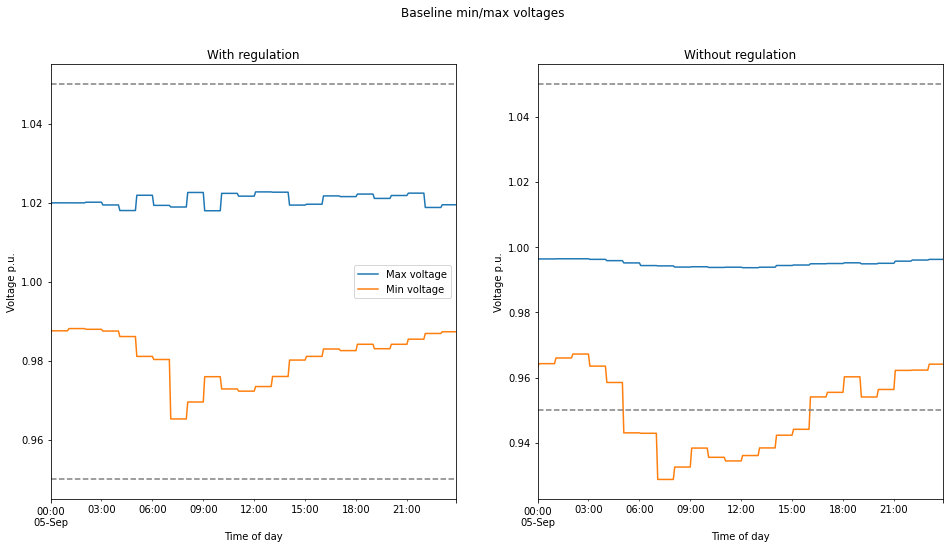

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
baseline_model.plot_dss_voltages(ax=ax[0], legend=True, title="With regulation")
baseline_model_no_reg.plot_dss_voltages(ax=ax[1], title="Without regulation")
fig.suptitle("Baseline min/max voltages");

Without voltage regulation this feeder experiences significant under-voltage issues. Because of this, we will constrain the rest of the experiments to the case with voltage regulation, as this is more realistic.

## Adding an adaptive charging network (ACN)

### Uncontrolled charging
Now, let's add one JPL ACN, with usage according to September 5, 2019 to node 2053 of the Iowa Feeder. This node's transformer has capacity 225 kVa, so large-scale EV charging may conceivably be added to this site, especially if scheduled charging is used to avoid overloading the transformer. However, let's first run a simple uncontrolled charging scenario, in which each EV is allowed to charge at its maximum rate. The configuration for such an experiment is below. We first specify ACN configurations that are unchanged throughout our experiments, and then set an algorithm for each experiment.

In [6]:
acn_base_experiment_configs = {"2053": {
    "site": "jpl",
    "start": datetime(2019, 9, 5),
    "end": datetime(2019, 9, 6),
    "alg_name": None,
    "tariff_name": "sce_tou_ev_4_march_2019",
    "external_load": baseline_model.open_dss_experiment.P["load_2053"].to_numpy(),
    "external_load_name": "load_2053_20170905",
    "bus_transformer_cap": 225,
}}

In [7]:
# Set ACN-Sim Experiment Algorithm.
acn_unctrl_configs = deepcopy(acn_base_experiment_configs)
for config in acn_unctrl_configs.values():
    config["alg_name"] = "unctrl"

# Build composite experiment.
unctrl_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_unctrl_configs,
)

In [8]:
# Run ACN-Sim Experiment
unctrl_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
unctrl_2053.add_acn_loads()

In [9]:
# Run OpenDSS Experiment
unctrl_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:28<00:00, 10.08it/s]


Let's see the effects of adding an uncontrolled ACN to the grid on the voltage
bounds.

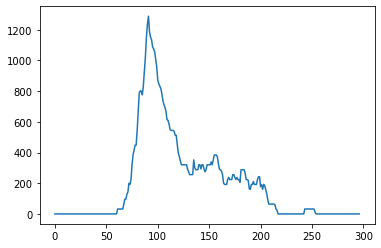

In [10]:
plt.plot(acnsim.aggregate_current(unctrl_2053.acn_experiments['2053'].sim))

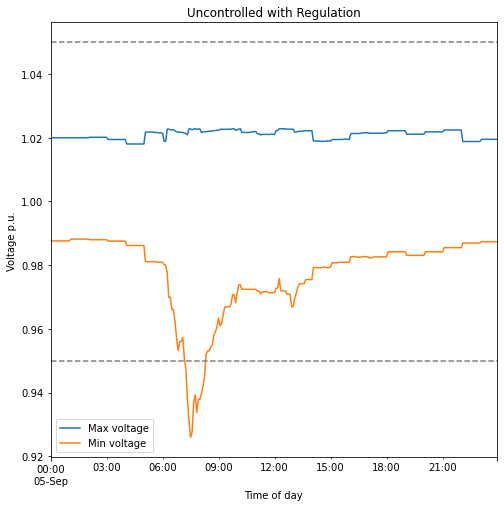

In [11]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
unctrl_2053.plot_dss_voltages(ax, legend=True, title="Uncontrolled with Regulation")

In [12]:
pd.concat(pd.DataFrame(val) for val in unctrl_2053.open_dss_experiment._overload_dict.values())[" %Normal"].groupby("Element").describe()

,count,mean,std,min,25%,50%,75%,max
Element,,,,,,,,
Transformer.T_2053,37.0,129.089189,23.956996,100.9,105.6,121.0,150.4,181.2


Adding an uncontrolled JPL ACN to node 2053 of the feeder causes large under-
voltage issues and transformer overlaod (up to 245% overuse).
Clearly, if we wish to add such an ACN without installing
new electrical infrastructure, we must schedule charging in some way
that is reactive to the already-existing demands of the system.

### Load flattening

One way to respond to the demand of the loads already at node 2053 is to
schedule EV charging such that the total load at the node is flattened. We use
a model predictive control algorithm with a primary objective of charging all
EVs and a secondary objective of flattening the total load on the node. For
example, this algorithm will avoid charging EVs when external load at 2053 is
high, and will charge EVs more when external load is low, such that the total
load is pushed towards 0. Additionally, the MPC framework allows for the sum of
external load and EV load to be limited by the transformer capacity of 225,
which we enforce to ensure the control parameters are reasonable.
Let's see if scheduling charging in this manner
decreases the undervoltage issue we observed for uncontrolled charging.

For this experiment, we will need more than 288 periods of baseline load
data, as the ACN experiment runs for longer. So, we first run the baseline 
scenario over a longer horizon.

In [13]:
longer_open_dss_experiment_config = deepcopy(open_dss_experiment_config)
longer_open_dss_experiment_config["horizon"] *= 2
longer_baseline = ACNOpenDSSCompositeExperiment(
    longer_open_dss_experiment_config
)
longer_baseline.run_dss()

100%|██████████| 576/576 [00:57<00:00, 10.00it/s]


In [14]:
# Set ACN-Sim Experiment Algorithm.
acn_load_flattening_configs = deepcopy(acn_base_experiment_configs)
for config in acn_load_flattening_configs.values():
    config["alg_name"] = "load_flattening"
    config["external_load"] = longer_baseline.open_dss_experiment.P["load_2053"].to_numpy()

# Build composite experiment.
load_flattening_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_load_flattening_configs
)

In [15]:
# Run ACN-Sim Experiment
load_flattening_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
load_flattening_2053.add_acn_loads()

/Users/sunash/opt/anaconda3/envs/acnportal-experiments-3.8/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:473: UserWarning: Scheduler adacharge.adacharge.AdaptiveSchedulingAlgorithm requires constructor inputs. Setting scheduler to BaseAlgorithm instead.
  warnings.warn(


In [16]:
# Run OpenDSS Experiment
load_flattening_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:27<00:00, 10.37it/s]


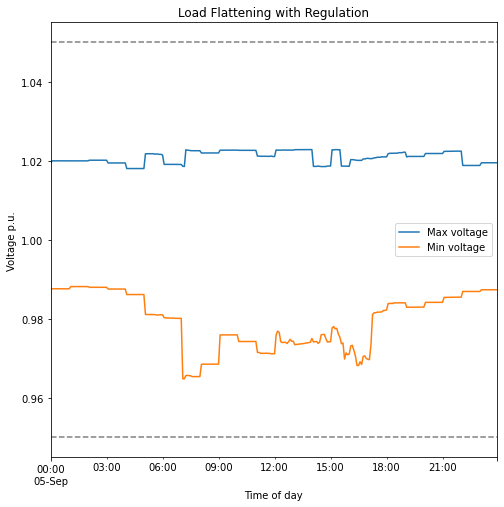

In [17]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
load_flattening_2053.plot_dss_voltages(ax, legend=True, title="Load Flattening with Regulation")

In [18]:
pd.concat(pd.DataFrame(val) for val in load_flattening_2053.open_dss_experiment._overload_dict.values())[" %Normal"]

Series([], Name:  %Normal, dtype: object)

### Load Flattening, no quick charge

In [19]:
# Set ACN-Sim Experiment Algorithm.
acn_load_flattening_no_qc_configs = deepcopy(acn_base_experiment_configs)
for config in acn_load_flattening_no_qc_configs.values():
    config["alg_name"] = "load_flattening_no_qc"
    config["external_load"] = longer_baseline.open_dss_experiment.P["load_2053"].to_numpy()

# Build composite experiment.
load_flattening_no_qc_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_load_flattening_no_qc_configs
)

In [20]:
# Run ACN-Sim Experiment
load_flattening_no_qc_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
load_flattening_no_qc_2053.add_acn_loads()

Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug E

/Users/sunash/opt/anaconda3/envs/acnportal-experiments-3.8/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:391: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  warnings.warn(


In [21]:
# Run OpenDSS Experiment
load_flattening_no_qc_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:27<00:00, 10.65it/s]


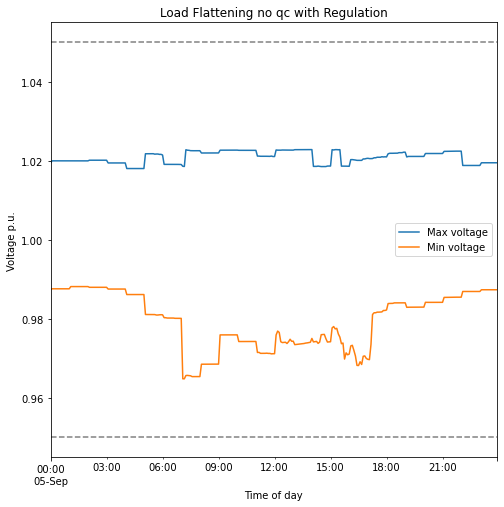

In [22]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
load_flattening_no_qc_2053.plot_dss_voltages(ax, legend=True, title="Load Flattening no qc with Regulation")

In [23]:
event_queue = acnsim.EventQueue.from_json("colab_data.json")
event_queue_new = unctrl_2053.acn_experiments["2053"].get_events()

/Users/sunash/opt/anaconda3/envs/acnportal-experiments-3.8/lib/python3.8/site-packages/acnportal/acnsim/base.py:577: UserWarning: Current version of dependency numpy does not match serialized version. Current: 1.19.2, Serialized: 1.18.5.
  warnings.warn(
/Users/sunash/opt/anaconda3/envs/acnportal-experiments-3.8/lib/python3.8/site-packages/acnportal/acnsim/base.py:577: UserWarning: Current version of dependency pandas does not match serialized version. Current: 1.1.3, Serialized: 1.1.5.
  warnings.warn(


In [24]:
for event_old, event_new in zip(event_queue._queue, event_queue_new._queue):
    for key in ['session_id', 'arrival']:
        print(f"Key {key} for old event: {getattr(event_old[1].ev, key)} for new event: {getattr(event_new[1].ev, key)}")

Key session_id for old event: 1_1_178_823_2019-09-05 03:19:03.949056 for new event: 1_1_178_828_2019-09-05 12:06:01.188971
Key arrival for old event: 39 for new event: 61
Key session_id for old event: 1_1_178_828_2019-09-05 12:06:01.188971 for new event: 1_1_179_799_2019-09-05 12:38:45.064371
Key arrival for old event: 145 for new event: 67
Key session_id for old event: 1_1_179_799_2019-09-05 12:38:45.064371 for new event: 1_1_178_823_2019-09-05 12:43:54.023353
Key arrival for old event: 151 for new event: 68
Key session_id for old event: 1_1_178_823_2019-09-05 12:43:54.023353 for new event: 1_1_193_819_2019-09-05 12:50:06.029538
Key arrival for old event: 152 for new event: 70
Key session_id for old event: 1_1_193_819_2019-09-05 12:50:06.029538 for new event: 1_1_193_825_2019-09-05 12:59:08.308350
Key arrival for old event: 154 for new event: 71
Key session_id for old event: 1_1_193_825_2019-09-05 12:59:08.308350 for new event: 1_1_193_820_2019-09-05 13:02:32.604829
Key arrival for ol

### Load Flattening, equal sharing

In [43]:
# Set ACN-Sim Experiment Algorithm.
acn_load_flattening_es_configs = deepcopy(acn_base_experiment_configs)
for config in acn_load_flattening_es_configs.values():
    config["alg_name"] = "load_flattening_es"
    config["external_load"] = longer_baseline.open_dss_experiment.P["load_2053"].to_numpy()

# Build composite experiment.
load_flattening_es_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_load_flattening_es_configs
)

In [44]:
# Run ACN-Sim Experiment
load_flattening_es_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
load_flattening_es_2053.add_acn_loads()

Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug E

/Users/sunash/opt/anaconda3/envs/acnportal-experiments-3.8/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:391: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  warnings.warn(


In [45]:
# Run OpenDSS Experiment
load_flattening_es_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:28<00:00, 10.15it/s]


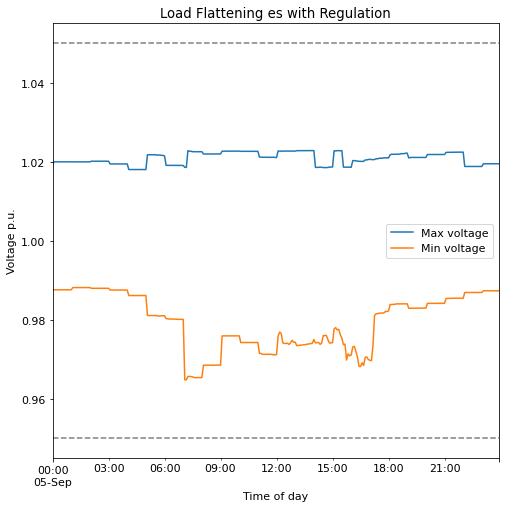

In [46]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
load_flattening_es_2053.plot_dss_voltages(ax, legend=True, title="Load Flattening es with Regulation")

(The empty series means there were no transformer overloads)

We see that the minimum voltage profile still contains a dip later in the day,
which is due to the load flattening algorithm increasing the aggregate charging
rate to meet the additional demand caused by EV arrivals later in the day. With
this algorithm, we don't have the same under voltage issues we had with
uncontrolled charging.

## Solar Data

We load solar data taken from NREL's System Advior Model (SAM) 
(https://sam.nrel.gov/). The data is for a 270 kW DC solar array on Sept 5,
2014 in Iowa, using default SAM parameters. 270 kW DC was chosen because it
corresponds to just below 225 kW AC at a 1.22 ratio, allowing for use with a
225 kVA transformer on bus 2053 of the feeder.

In [82]:
pv_year = 2014
pv_data = pd.read_csv("data/results_des_moines_autosized_270kWdc.csv")
pv_data["Time stamp"] = [f"{pv_year} {ts}" for ts in pv_data["Time stamp"]]
pv_data["Time stamp"] = pd.to_datetime(pv_data["Time stamp"])
pv_data = pv_data.set_index("Time stamp")
# Rescale PV generation to AC capacity, and follow consumer-perspective sign convention (negative for generation)
pv_data["AC Power | (kW)"] = -1 * pv_data["Array DC power | (kW)"] / 1.22
pv_data = pv_data.resample("5T").ffill()
trunc_gen = pv_data.loc[datetime(pv_year, 9, 5):]["AC Power | (kW)"].to_numpy()
external_load_2053 = longer_baseline.open_dss_experiment.P["load_2053"].to_numpy()
external_load_and_gen_2053 = external_load_2053 + trunc_gen[:len(external_load_2053)]
solar_gen = trunc_gen[:len(external_load_2053)]

In [83]:
# Set default ACN-Sim experiment configs.
acn_solar_experiment_configs = {"2053": {
    "site": "jpl",
    "start": datetime(2019, 9, 5),
    "end": datetime(2019, 9, 6),
    "alg_name": None,
    "tariff_name": "sce_tou_ev_4_march_2019",
    "external_load": external_load_and_gen_2053,
    "external_load_name": "load_gen_2053_20170905",
    "bus_transformer_cap": 225,
}}

In [84]:
# Set ACN-Sim Experiment Algorithm.
acn_solar_load_flattening_configs = deepcopy(acn_solar_experiment_configs)
for config in acn_solar_load_flattening_configs.values():
    config["alg_name"] = "load_flattening_es"

# Build composite experiment.
solar_load_flattening_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_solar_load_flattening_configs, 
)


In [85]:
# Run ACN-Sim Experiment
solar_load_flattening_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
solar_load_flattening_2053.add_acn_loads()

# Add solar load to the OpenDSS Experiment
solar_load_flattening_2053.add_general_loads(solar_gen)

Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug E

/Users/sunash/opt/anaconda3/envs/acnportal-experiments-3.8/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:391: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  warnings.warn(


In [86]:
# Run OpenDSS Experiment
solar_load_flattening_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:29<00:00,  9.83it/s]


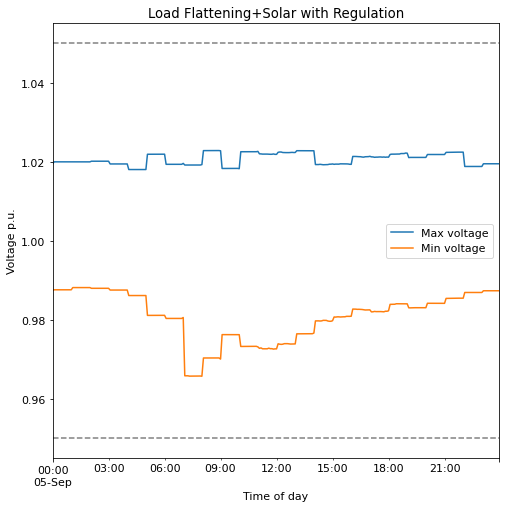

In [87]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
solar_load_flattening_2053.plot_dss_voltages(ax, legend=True, title="Load Flattening+Solar with Regulation")

In [88]:
pd.concat(pd.DataFrame(val) for val in solar_load_flattening_2053.open_dss_experiment._overload_dict.values())[" %Normal"]

Series([], Name:  %Normal, dtype: object)

(The empty series means there were no transformer overloads)

We see that the minimum and maximum voltage profiles look very similar to the
baseline profiles. The interpretation of this is twofold: first, adding the one
solar array to the feeder does not cause an over-voltage issue in the grid.
Second, load flattening against solar (i.e. charging EVs when solar is more
available) eliminates any under-voltage issues from the ACN; moreover, solar
and load flattening essentially eliminates any effect of the ACN on the minimal
voltage.

The plot below shows the under-voltage deviations from all scenarios together.
Note that the curves for the baseline and load flattening + solar
under-voltages are essentially co-located. With solar, we can make it so that
the ACN has no effect on upper and lower voltage bounds of the entire grid.

In [81]:
a = pd.DataFrame({"net_min" : unctrl_2053.open_dss_experiment.voltage_pu.min()})
a['agg'] = acnsim.aggregate_current(unctrl_2053.acn_experiments['2053'].sim)[:288]
a

,net_min,agg
2017-09-05 00:00:00,0.987413,0.0
2017-09-05 00:05:00,0.987597,0.0
2017-09-05 00:10:00,0.987597,0.0
2017-09-05 00:15:00,0.987597,0.0
2017-09-05 00:20:00,0.987597,0.0
...,...,...
2017-09-05 23:35:00,0.987353,0.0
2017-09-05 23:40:00,0.987353,0.0
2017-09-05 23:45:00,0.987353,0.0
2017-09-05 23:50:00,0.987353,0.0


In [126]:
acn_exp_names = ["unctrl", "lf", "solar_lf"]
df_dict = {"baseline": pd.DataFrame({"net_min" : baseline_model.open_dss_experiment.voltage_pu.min()})}
df_dict["baseline"]["solar_gen"] = solar_gen[:288]
df_dict["baseline"]["background_load"] = external_load_2053[:288]
print(df_dict["baseline"])
for name, exp in zip(acn_exp_names,
                     [unctrl_2053, load_flattening_es_2053, solar_load_flattening_2053]):
    df = pd.DataFrame({"net_min" : exp.open_dss_experiment.voltage_pu.min()})
    df['agg'] = acnsim.aggregate_current(exp.acn_experiments['2053'].sim)[:288]
    df_dict[name] = df

                      net_min  solar_gen  background_load
2017-09-05 00:00:00  0.987413       -0.0             4.20
2017-09-05 00:05:00  0.987597       -0.0             4.20
2017-09-05 00:10:00  0.987597       -0.0             4.20
2017-09-05 00:15:00  0.987597       -0.0             4.20
2017-09-05 00:20:00  0.987597       -0.0             4.20
...                       ...        ...              ...
2017-09-05 23:35:00  0.987353       -0.0            39.96
2017-09-05 23:40:00  0.987353       -0.0            39.96
2017-09-05 23:45:00  0.987353       -0.0            39.96
2017-09-05 23:50:00  0.987353       -0.0            39.96
2017-09-05 23:55:00  0.987353       -0.0            39.96

[288 rows x 3 columns]


In [109]:
df_dict["lf"]["agg"]

2017-09-05 00:00:00    0.000000
2017-09-05 00:05:00    0.000000
2017-09-05 00:10:00    0.000000
2017-09-05 00:15:00    0.000000
2017-09-05 00:20:00    0.000000
                         ...   
2017-09-05 23:35:00    0.000106
2017-09-05 23:40:00    0.000101
2017-09-05 23:45:00    0.000096
2017-09-05 23:50:00    0.000092
2017-09-05 23:55:00    0.000088
Name: agg, Length: 288, dtype: float64

unctrl
lf
solar_lf


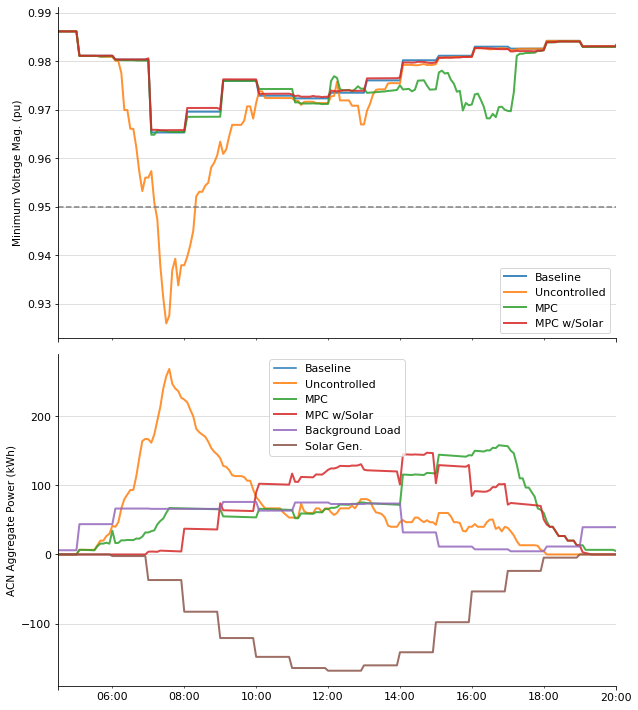

In [136]:
fig, axs = plt.subplots(2, sharex=True)
style = {
    "linewidth": 2,
    "alpha": .85,
}

plt.xlim((25076460.0, 25077300.0))
ax0 = axs[0]
ax1 = axs[1]
for key in ["baseline"] + acn_exp_names:
    df_dict[key]["net_min"].plot(ax=ax0, **style)
    
# baseline_model.open_dss_experiment.voltage_pu.min().plot(ax=ax0, **style)
# unctrl_2053.open_dss_experiment.voltage_pu.min().plot(ax=ax0, **style)
# load_flattening_2053.open_dss_experiment.voltage_pu.min().plot(ax=ax0, **style)
# solar_load_flattening_2053.open_dss_experiment.voltage_pu.min().plot(ax=ax0, **style)

# Skip the first color.
ax1.plot([0], label="_no_legend_")
for key in acn_exp_names:
    print(key)
    (df_dict[key]["agg"]*208/1000).plot(ax=ax1, **style)
# ax1.plot(acnsim.aggregate_current(unctrl_2053.acn_experiments['2053'].sim), **style)
# ax1.plot(acnsim.aggregate_current(load_flattening_2053.acn_experiments['2053'].sim), **style)
# # ax.plot(load_flattening_2053_dates, acnsim.aggregate_current(load_flattening_es_2053.acn_experiments['2053'].sim), **style)
# ax1.plot(acnsim.aggregate_current(solar_load_flattening_2053.acn_experiments['2053'].sim), **style)

df_dict["baseline"]["background_load"].plot(ax=ax1, **style)
df_dict["baseline"]["solar_gen"].plot(ax=ax1, **style)

ax0.set_ylabel("Minimum Voltage Mag. (pu)", fontsize=10.5)
ax1.set_ylabel("ACN Aggregate Power (kWh)", fontsize=10.5)
ax0.legend(["Baseline", "Uncontrolled", "MPC", "MPC w/Solar", "Background Load", "Solar Gen."])
ax1.legend(["Baseline", "Uncontrolled", "MPC", "MPC w/Solar", "Background Load", "Solar Gen."])
ax0.axhline(0.95, linestyle="--", color="grey")
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.rc('text', usetex=False)
    plt.rcParams.update({'font.size': 11})
    plt.xlim((25076430.0, 25077360.0))
    ax.grid(alpha=0.5)
    ax.grid(alpha=0.5)
    fig = plt.gcf()
    fig.set_size_inches(9, 5*len(axs))
    plt.tight_layout()
plt.savefig("iowa_feeder_w_agg.pdf", format="pdf")

Let's check the energy delivered for each scenario with an ACN.

In [33]:
unctrl_energy_delivered = acnsim.proportion_of_energy_delivered(
    unctrl_2053.acn_experiments["2053"].sim
)
load_flattening_energy_delivered = acnsim.proportion_of_energy_delivered(
    load_flattening_2053.acn_experiments["2053"].sim
)
solar_load_flattening_energy_delivered = acnsim.proportion_of_energy_delivered(
    solar_load_flattening_2053.acn_experiments["2053"].sim
)
print(
    f"Energy delivered with Uncontrolled Charging: "
    f"{unctrl_energy_delivered}\n"
    f"Energy delivered with Load Flattening: "
    f"{load_flattening_energy_delivered}\n"
    f"Energy delivered with Load Flattening and Solar: "
    f"{solar_load_flattening_energy_delivered}\n"
)

Energy delivered with Uncontrolled Charging: 1.0
Energy delivered with Load Flattening: 0.9954631486400282
Energy delivered with Load Flattening and Solar: 0.9999996388902505



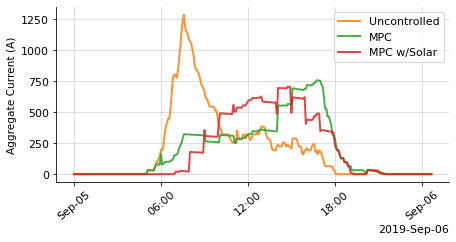

In [48]:
unctrl_2053_dates = mdates.date2num(acnsim.datetimes_array(unctrl_2053.acn_experiments['2053'].sim))
load_flattening_2053_dates = mdates.date2num(acnsim.datetimes_array(load_flattening_2053.acn_experiments['2053'].sim))
solar_load_flattening_2053_dates = mdates.date2num(acnsim.datetimes_array(solar_load_flattening_2053.acn_experiments['2053'].sim))

locator = mdates.AutoDateLocator(maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)

fig, ax = plt.subplots(sharex=True)
style = {
    "linewidth": 2,
    "alpha": .85,
}
# Skip the first color.
ax.plot([],[], label="_nolegend_")
ax.plot(unctrl_2053_dates, acnsim.aggregate_current(unctrl_2053.acn_experiments['2053'].sim), **style)
ax.plot(load_flattening_2053_dates, acnsim.aggregate_current(load_flattening_2053.acn_experiments['2053'].sim), **style)
# ax.plot(load_flattening_2053_dates, acnsim.aggregate_current(load_flattening_es_2053.acn_experiments['2053'].sim), **style)
ax.plot(solar_load_flattening_2053_dates, acnsim.aggregate_current(solar_load_flattening_2053.acn_experiments['2053'].sim), **style)
for label in ax.get_xticklabels():
        label.set_rotation(40)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel("Aggregate Current (A)", fontsize=10.5)
ax.legend(["Uncontrolled", "MPC", "MPC w/Solar"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.xlim((25076460.0, 25077300.0))
# ax.axhline(0.95, linestyle="--", color="grey")
plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 11})
ax.grid(alpha=0.5)
ax.grid(alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(6.47, 3.5)
plt.tight_layout()